In [1]:
import glob
import os
import json

import pandas as pd
import numpy as np
import nibabel as nib

import fastai
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

import scipy.ndimage 
from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

from useful_functions import *

In [2]:
bids_dir = "bids-new"

In [3]:
session_dirs = []
for json_path in sorted(glob.glob(os.path.join(bids_dir, "sub*", "ses*", "anat", "*echo-01*mag*json"))):
    with open(json_path, 'r') as json_file:
        json_data = json.load(json_file)
        if json_data['ProtocolName'] == "t2starME_qsm_tra_Iso1.4mm_INPHASE_bipolar_RUN_THIS_ONE":
            session_dirs.append(os.sep.join(os.path.split(json_path)[0].split(os.sep)[:-1]))
print(f"{len(session_dirs)} sessions found:")
for session_dir in session_dirs: print(session_dir)

15 sessions found:
bids-new/sub-z0034542/ses-20220715
bids-new/sub-z0186251/ses-20221107
bids-new/sub-z0705200/ses-20230104
bids-new/sub-z0755228/ses-20211108
bids-new/sub-z1167038/ses-20220315
bids-new/sub-z1181657/ses-20220315
bids-new/sub-z1262112/ses-20220314
bids-new/sub-z1472355/ses-20221222
bids-new/sub-z1728751/ses-20220328
bids-new/sub-z1778013/ses-20220715
bids-new/sub-z1818796/ses-20230313
bids-new/sub-z2007565/ses-20220715
bids-new/sub-z2904752/ses-20220826
bids-new/sub-z3171177/ses-20230313
bids-new/sub-z3278008/ses-20211109


In [4]:
qsm_files = [glob.glob(os.path.join(session_dir, "extra_data", "*qsm_echo2-and-echo4.*")) for session_dir in session_dirs]
seg_files = [glob.glob(os.path.join(session_dir, "extra_data", "*segmentation_clean.*")) for session_dir in session_dirs]
ct_files = [glob.glob(os.path.join(session_dir, "extra_data", "*_na_*.nii*")) for session_dir in session_dirs] + \
           [glob.glob(os.path.join(session_dir, "extra_data", "*_Pelvis_*.nii*")) for session_dir in session_dirs]
t2s_files = [glob.glob(os.path.join(session_dir, "extra_data", "*t2starmap.nii*")) for session_dir in session_dirs]
mag_files = [glob.glob(os.path.join(session_dir, "anat", "*echo-04*part-mag*.nii*")) for session_dir in session_dirs]

qsm_files = [qsm_file_list[0] for qsm_file_list in qsm_files if len(qsm_file_list)]
seg_files = [seg_file_list[0] for seg_file_list in seg_files if len(seg_file_list)]
ct_files = sorted(list(set([ct_file_list[0] for ct_file_list in ct_files if len(ct_file_list)])))
t2s_files = [t2s_file_list[0] for t2s_file_list in t2s_files if len(t2s_file_list)]
mag_files = [mag_file_list[0] for mag_file_list in mag_files if len(mag_file_list)]

print(f"{len(ct_files)} CT images found.")
print(f"{len(qsm_files)} QSM images found.")
print(f"{len(mag_files)} magnitude images found.")
print(f"{len(t2s_files)} T2* maps found.")
print(f"{len(seg_files)} segmentations found.")

15 CT images found.
15 QSM images found.
15 magnitude images found.
15 T2* maps found.
15 segmentations found.


In [5]:
seg_files

['bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii',
 'bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii',
 'bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz',
 'bids-new/sub-z1778013/s

# Gold marker segmentation with QSM

## Prepare data
### Locate input data

The files are 3D NIfTI images.

In [6]:
# input data
#qsm_files = [x for x in sorted(glob.glob(f"{bids_dir}/sub-*/ses-*/extra_data/*qsm.nii*"))]
#seg_files = [x for x in sorted(glob.glob(f"{bids_dir}/sub-*/ses-*/extra_data/*segmentation*clean.nii*"))]
#t2s_files = [x for x in sorted(glob.glob(f"{bids_dir}/sub-*/ses-*/extra_data/*t2starmap.nii*"))]
#mag_files = [x for x in sorted(glob.glob(f"{bids_dir}/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))]
assert(len(qsm_files) == len(seg_files))
df = pd.DataFrame({ 'qsm_files' : qsm_files, 'seg_files' : seg_files, 't2s_files' : t2s_files })
df

,qsm_files,seg_files,t2s_files
0,bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_qsm_echo2-and-echo4.nii,bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean.nii.gz,bids-new/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_t2starmap.nii.gz
1,bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_qsm_echo2-and-echo4.nii,bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_segmentation_clean.nii.gz,bids-new/sub-z0186251/ses-20221107/extra_data/sub-z0186251_ses-20221107_run-01_t2starmap.nii.gz
2,bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_qsm_echo2-and-echo4.nii,bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_segmentation_clean.nii,bids-new/sub-z0705200/ses-20230104/extra_data/sub-z0705200_ses-20230104_run-01_t2starmap.nii.gz
3,bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_qsm_echo2-and-echo4.nii,bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_segmentation_clean.nii.gz,bids-new/sub-z0755228/ses-20211108/extra_data/sub-z0755228_ses-20211108_run-01_t2starmap.nii.gz
4,bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_qsm_echo2-and-echo4.nii,bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_segmentation_clean.nii.gz,bids-new/sub-z1167038/ses-20220315/extra_data/sub-z1167038_ses-20220315_run-01_t2starmap.nii.gz
5,bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_qsm_echo2-and-echo4.nii,bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_segmentation_clean.nii.gz,bids-new/sub-z1181657/ses-20220315/extra_data/sub-z1181657_ses-20220315_run-01_t2starmap.nii.gz
6,bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_qsm_echo2-and-echo4.nii,bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_segmentation_clean.nii.gz,bids-new/sub-z1262112/ses-20220314/extra_data/sub-z1262112_ses-20220314_run-01_t2starmap.nii.gz
7,bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_qsm_echo2-and-echo4.nii,bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_segmentation_clean.nii,bids-new/sub-z1472355/ses-20221222/extra_data/sub-z1472355_ses-20221222_run-01_t2starmap.nii.gz
8,bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_qsm_echo2-and-echo4.nii,bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_segmentation_clean.nii.gz,bids-new/sub-z1728751/ses-20220328/extra_data/sub-z1728751_ses-20220328_run-01_t2starmap.nii.gz
9,bids-new/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_qsm_echo2-and-echo4.nii,bids-new/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_segmentation_clean.nii.gz,bids-new/sub-z1778013/ses-20220715/extra_data/sub-z1778013_ses-20220715_run-01_t2starmap.nii.gz


In [7]:
train_df, test_df = train_test_split(df, test_size=3, random_state=42)
print(f"Training samples shape: {train_df.shape}")
print(f"Testing samples shape: {test_df.shape}")

med_dataset = MedDataset(
    img_list=train_df.seg_files.tolist(),
    dtype=MedMask
)

suggested_voxelsize, requires_resampling = med_dataset.suggestion()
largest_imagesize = med_dataset.get_largest_img_size(resample=suggested_voxelsize)
print(f"Suggested voxel size: {suggested_voxelsize}")
print(f"Requires resampling: {requires_resampling}")
print(f"Largest image size: {largest_imagesize}")

Training samples shape: (12, 3)
Testing samples shape: (3, 3)
Suggested voxel size: [1.4, 1.4, 1.4]
Requires resampling: False
Largest image size: [146.0, 160.0, 72.0]


In [8]:
def get_center_slices(mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)
    center_slices = [[round(coord) for coord in region.centroid] for region in regions]
    return center_slices

class SetVrange(DisplayedTransform):
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def encodes(self, o:MedImage):
        o[o > self.vmax] = 0
        o[o < self.vmin] = 0
        return o
    
def show_images(x, y, figsize=None, fig_out=None):
    n_samples = x.shape[0]
    n_masks = y.shape[0]
    assert(n_samples == n_masks)
    n_samples = max(1, n_samples)

    if y.shape[1] > 1:
        mask = torch.argmax(y, dim=1).unsqueeze(1).cpu().numpy()
    else:
        mask = y.cpu().numpy()
    mask = np.array(np.round(mask), dtype=int)
    qsm = x.cpu().numpy()

    max_sources = 1
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)
        max_sources = max(n_sources, max_sources)
    max_sources = min(7, max_sources)

    img_width = 2
    img_height = 2
    wspace = 0.05
    hspace = 0.05
    n_cols = max_sources
    n_rows = n_samples
    fig_width = img_width * n_cols + wspace * (n_cols - 1)
    fig_height = img_height * n_rows + hspace * (n_rows - 1)

    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(fig_width, fig_height), squeeze=False)
    
    for ax in axes.flat:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    
    for i in range(n_rows):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)

        for j in range(min(n_sources, n_cols)):
            axes[i,j].imshow(qsm[i][0][center_slices[j][0],:,:], cmap='gray', vmin=-5, vmax=+5, interpolation='nearest') 
            axes[i,j].imshow(mask[i][0][center_slices[j][0],:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(mask[i][0][center_slices[j][0],:,:] != 0, dtype=int) * 0.6, interpolation='nearest')
    plt.tight_layout()
    if fig_out: plt.savefig(fig_out)
    plt.show()
    plt.close()
    
@typedispatch
def show_batch(x:MedImage, y:MedMask, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    show_images(x, y)
    

Training examples: 10
Validation examples: 2


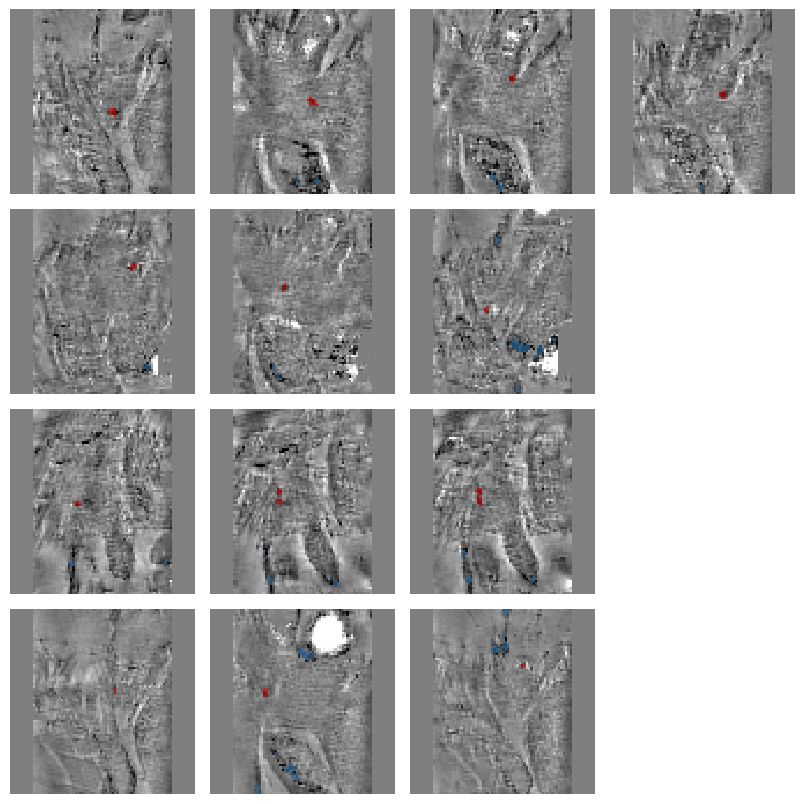

In [9]:
dblock = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),#seed=42),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        RandomFlip(axes=("LR",)),
        RandomFlip(axes=("AP",)),
        RandomAffine(degrees=(90, 90, 90)),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls = DataLoaders.from_dblock(dblock, train_df, bs=4)
print(f"Training examples: {len(dls.train_ds.items)}")
print(f"Validation examples: {len(dls.valid_ds.items)}")
dls.show_batch(anatomical_plane=2)

In [10]:
class MarkersIdentified(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn=None, pred=None, targ=None):
        if pred is None or targ is None:
            pred = learn.pred.argmax(dim=1).cpu().numpy()
            targ = learn.y.cpu().numpy()
        
        pred = np.array(np.round(pred), dtype=int)
        targ = np.array(np.round(targ), dtype=int)

        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i] == 1)
            _, targ_nlabels = scipy.ndimage.label(targ[i] == 1)
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.overlap_count) / max(1., float(self.targ_marker_count))

class SuperfluousMarkers(fastai.metrics.Metric):
    def __init__(self):
        super().__init__()
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def reset(self):
        self.targ_marker_count = 0
        self.pred_marker_count = 0
        self.overlap_count = 0
    
    def accumulate(self, learn=None, pred=None, targ=None):
        if pred is None or targ is None:
            pred = learn.pred.argmax(dim=1).cpu().numpy()
            targ = learn.y.cpu().numpy()
        
        pred = np.array(np.round(pred), dtype=int)
        targ = np.array(np.round(targ), dtype=int)

        for i in range(targ.shape[0]):
            _, pred_nlabels = scipy.ndimage.label(pred[i] == 1)
            _, targ_nlabels = scipy.ndimage.label(targ[i] == 1)
            overlap = np.array(np.logical_and(pred[i] == targ[i], pred[i] == 1), dtype=int)
            _, n_overlaps = scipy.ndimage.label(overlap)
            
            self.pred_marker_count += pred_nlabels
            self.targ_marker_count += targ_nlabels
            self.overlap_count += n_overlaps

    @property
    def value(self):
        return float(self.pred_marker_count - self.overlap_count) / max(1., float(self.pred_marker_count))

In [11]:
learn = Learner(
    dls,
    model=UNet(
        spatial_dims=3,
        in_channels=1,  # qsm
        out_channels=3, # background, marker, calcification
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2
    ),
    loss_func=DiceCELoss(
        to_onehot_y=True,
        include_background=True,
        softmax=True
    ),
    opt_func=ranger,
    metrics=[multi_dice_score, MarkersIdentified(), SuperfluousMarkers()]#.to_fp16()
)

In [12]:
lr = 0.003

In [ ]:
learn.load('prostate-model')

In [13]:
learn.fit_flat_cos(400, lr)

In [19]:
learn.save('prostate-model')

Path('models/prostate-model.pth')

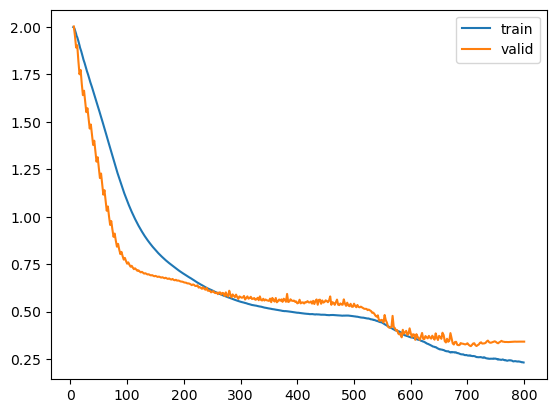

In [14]:
learn.recorder.plot_loss()

In [81]:
def show_images(x, y, figsize=None, fig_out='out.png'):
    n_samples = x.shape[0]
    n_masks = y.shape[0]
    assert(n_samples == n_masks)
    n_samples = max(1, n_samples)

    if y.shape[1] > 1:
        mask = torch.argmax(y, dim=1).unsqueeze(1).cpu().numpy()
    else:
        mask = y.cpu().numpy()
    mask = np.array(np.round(mask), dtype=int)
    qsm = x.cpu().numpy()

    max_sources = 1
    for i in range(n_samples):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)
        max_sources = max(n_sources, max_sources)
    max_sources = min(7, max_sources)

    img_width = 2.5
    img_height = 2.5
    wspace = 0.05
    hspace = 0.05
    n_cols = max_sources
    n_rows = n_samples
    fig_width = img_width * n_cols + wspace * (n_cols - 1)
    fig_height = img_height * n_rows + hspace * (n_rows - 1)

    fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(fig_width, fig_height), squeeze=False)
    
    for ax in axes.flat:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    
    for i in range(n_rows):
        center_slices = get_center_slices(np.array(mask[i][0] == 1, dtype=int))
        n_sources = len(center_slices)

        for j in range(min(n_sources, n_cols)):
            axes[i,j].imshow(qsm[i][0][center_slices[j][0],:,:], cmap='gray', vmin=-5, vmax=+5, interpolation='nearest') 
            axes[i,j].imshow(mask[i][0][center_slices[j][0],:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(mask[i][0][center_slices[j][0],:,:] != 0, dtype=int) * 0.6, interpolation='nearest')
    plt.tight_layout()
    if fig_out: plt.savefig(fig_out)
    plt.show()
    plt.close()

@typedispatch
def show_results(x:MedImage, y:MedMask, samples, outs, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, fig_out='out.png', **kwargs):
    outs = torch.stack([outs[i][0] for i in range(len(outs))], dim=0)
    print("TARG")
    show_images(x, y, fig_out=f"{fig_out.split('.')[0]}_targ.png")
    print("PRED")
    show_images(x, outs, fig_out=f"{fig_out.split('.')[0]}_pred.png")

In [16]:
# Compute metrics on the entire training dataset
sf_markers = SuperfluousMarkers()
correct_markers = MarkersIdentified()

dblock_train_eval = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=IndexSplitter([]),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)
dls_train_eval = DataLoaders.from_dblock(dblock_train_eval, train_df, bs=1, sampler=SequentialSampler)
for x, y in dls_train_eval.train:
    pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
    sf_markers.accumulate(pred=pred, targ=y)
    correct_markers.accumulate(pred=pred, targ=y)

print(sf_markers.value)
print(correct_markers.value)
print(f"Predicted markers: {correct_markers.pred_marker_count}")
print(f"Correct markers: {correct_markers.overlap_count}")
print(f"Incorrect markers: {correct_markers.pred_marker_count - correct_markers.overlap_count}")
print(f"Target markers: {correct_markers.targ_marker_count}")

sf_markers.reset()
correct_markers.reset()

dblock_test_eval = MedDataBlock(
    blocks=(ImageBlock(cls=MedImage), MedMaskBlock),
    splitter=RandomSplitter(),
    get_x=ColReader('qsm_files'),
    get_y=ColReader('seg_files'),
    item_tfms=[
        PadOrCrop([80, 80, 80]),
        ZNormalization(),
    ],
    reorder=requires_resampling,
    resample=suggested_voxelsize
)

dls_test_eval = DataLoaders.from_dblock(dblock_test_eval, test_df, bs=1, sampler=SequentialSampler)
for x, y in dls_test_eval.train:
    pred = torch.argmax(learn.model(x), dim=1).unsqueeze(1).to(dtype=torch.float)
    sf_markers.accumulate(pred=pred, targ=y)
    correct_markers.accumulate(pred=pred, targ=y)

print(sf_markers.value)
print(correct_markers.value)
print(f"Predicted markers: {correct_markers.pred_marker_count}")
print(f"Correct markers: {correct_markers.overlap_count}")
print(f"Incorrect markers: {correct_markers.pred_marker_count - correct_markers.overlap_count}")
print(f"Target markers: {correct_markers.targ_marker_count}")

0.0
0.7619047619047619
Predicted markers: 32
Correct markers: 32
Incorrect markers: 0
Target markers: 42
0.14285714285714285
0.6666666666666666
Predicted markers: 7
Correct markers: 6
Incorrect markers: 1
Target markers: 9


In [17]:
learn.show_results(anatomical_plane=0, dl=dls_train_eval.train, fig_out='seg_results_train.png')
loss, *metrics = learn.validate(ds_idx=0, dl=dls_train_eval.train)
print("TRAINING SET METRICS")
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

TRAINING SET METRICS
Dice score: tensor([0.8417, 0.7123]); Markers identified: 0.7619047619047619; Superfluous markers: 0.0


In [18]:
learn.show_results(anatomical_plane=0, dl=dls_test_eval.train, fig_out='seg_results_test.png')
loss, *metrics = learn.validate(ds_idx=0, dl=dls_test_eval.train)
print("TEST SET METRICS")
print(f"Dice score: {metrics[0]}; Markers identified: {metrics[1]}; Superfluous markers: {metrics[2]}")

TEST SET METRICS
Dice score: tensor([0.5422, 0.3327]); Markers identified: 0.6666666666666666; Superfluous markers: 0.14285714285714285


Text(0.5, 1.0, 'FMs identified and Dice Scores')

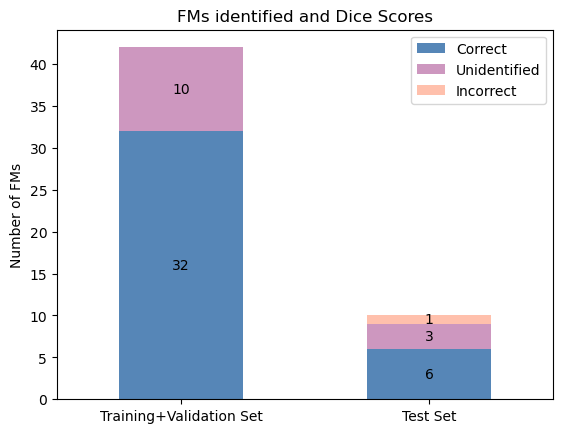

In [58]:
import seaborn
import pandas as pd

df_results = pd.DataFrame({ 'Correct':[32, 6], 'Unidentified': [10, 3], 'Incorrect':[0,1], 'Set':['Training', 'Validation'] })

# create stacked bar chart for monthly temperatures
fig, ax1 = plt.subplots()
ax1 = df_results.plot(kind='bar', stacked=True, color=['#5686b7', '#cd97bf', '#ffc0ac'], ax=ax1)

ax1.set_xticklabels(['Training+Validation Set', 'Test Set'], rotation=0)

for p in ax1.patches:
    width, height = p.get_width(), p.get_height()
    if height != 0:
        x, y = p.get_xy()
        ax1.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center')

# labels for x & y axis
ax1.set_ylabel('Number of FMs')

# Dice scores for training and validation sets
dice_scores = [0.8417, 0.5422]  # Replace with your actual Dice scores

# title of plot
plt.title('FMs identified and Dice Scores')

TARG


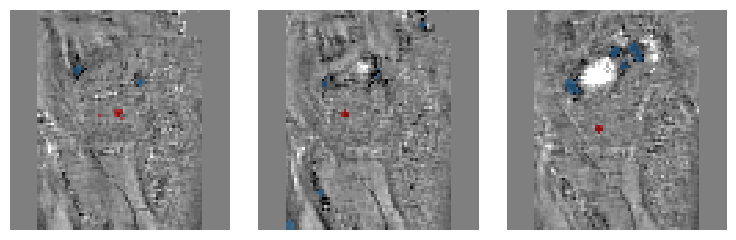

PRED


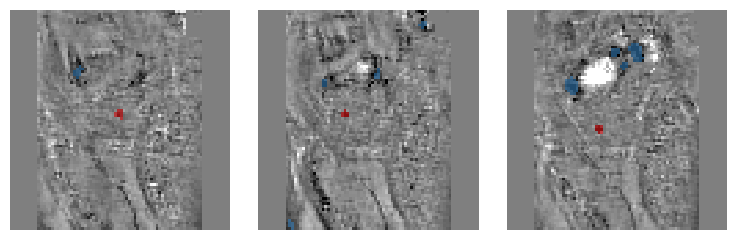

In [82]:
learn.show_results(anatomical_plane=0, dl=dls_train_eval.train, shuffle=False, fig_out='seg_results_train.png')

In [237]:
def get_cropped_regions(y, preds, inputs, cropsize=10):
    from scipy.ndimage import label
    labeled_mask, num_labels = label(
        input=preds == 1,
        structure=np.ones((3, 3, 3))
    )

    input_regions = []
    y_regions = []
    pred_regions = []

    for region_label in range(1, num_labels+1):
        coords = np.argwhere(labeled_mask == region_label)

        centroid = np.mean(coords, axis=0)
        centroid = np.round(centroid).astype(int)

        half_cropsize = cropsize // 2

        y_region = y[
            max(0, centroid[0]-half_cropsize):min(y.shape[0], centroid[0]+half_cropsize),
            max(0, centroid[1]-half_cropsize):min(y.shape[1], centroid[1]+half_cropsize),
            max(0, centroid[2]-half_cropsize):min(y.shape[2], centroid[2]+half_cropsize)
        ]
        pred_region = preds[
            max(0, centroid[0]-half_cropsize):min(preds.shape[0], centroid[0]+half_cropsize),
            max(0, centroid[1]-half_cropsize):min(preds.shape[1], centroid[1]+half_cropsize),
            max(0, centroid[2]-half_cropsize):min(preds.shape[2], centroid[2]+half_cropsize)
        ]
        input_region = inputs[
            max(0, centroid[0]-half_cropsize):min(preds.shape[0], centroid[0]+half_cropsize),
            max(0, centroid[1]-half_cropsize):min(preds.shape[1], centroid[1]+half_cropsize),
            max(0, centroid[2]-half_cropsize):min(preds.shape[2], centroid[2]+half_cropsize)
        ]

        input_regions.append(input_region)
        y_regions.append(y_region)
        pred_regions.append(pred_region)

    return input_regions, pred_regions, y_regions

In [286]:
inputs, preds, y = learn.get_preds(0, dl=dls_test_eval.train, with_input=True)
preds = torch.argmax(preds, dim=1).unsqueeze(1)

inputs = inputs.cpu().numpy()
preds = preds.cpu().numpy()
y = y.cpu().numpy()

In [287]:
print(inputs.shape)
print(preds.shape)
print(y.shape)

(3, 1, 80, 80, 80)
(3, 1, 80, 80, 80)
(3, 1, 80, 80, 80)


4


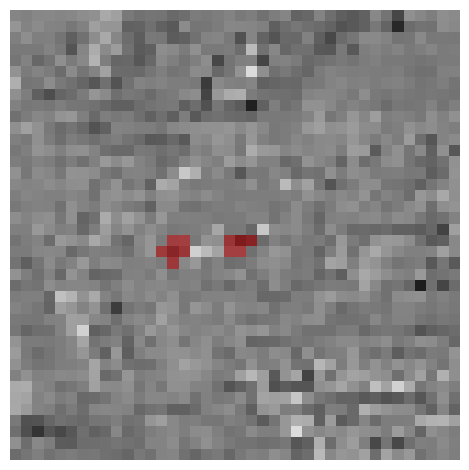

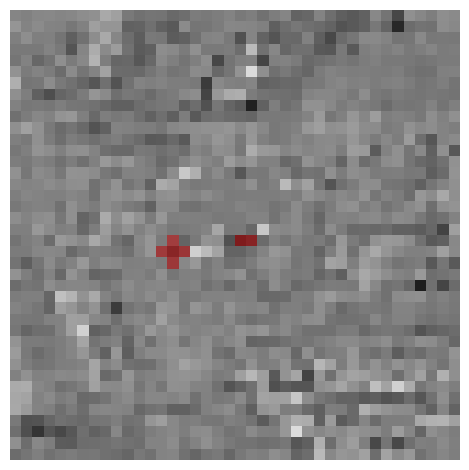

In [288]:
i = 0
j = 1
center_slices = get_center_slices(np.array(y[i][0] == 1, dtype=int))

input_regions, pred_regions, y_regions = get_cropped_regions(y[i][0], preds[i][0], inputs[i][0], cropsize=40)
print(len(input_regions))
slice_idx = input_regions[j].shape[0] // 2

fig = plt.figure()
plt.axis('off')
plt.imshow(input_regions[j][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(y_regions[j][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(y_regions[j][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure()
plt.axis('off')
plt.imshow(input_regions[j][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(pred_regions[j][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(pred_regions[j][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()

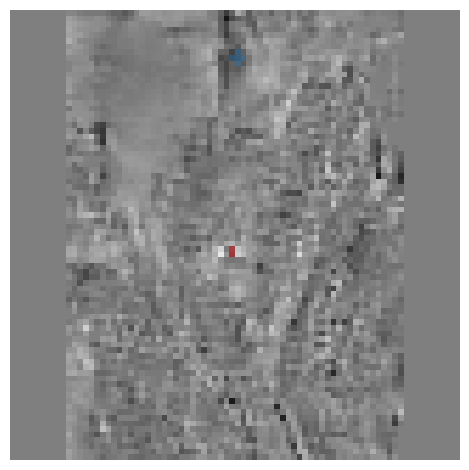

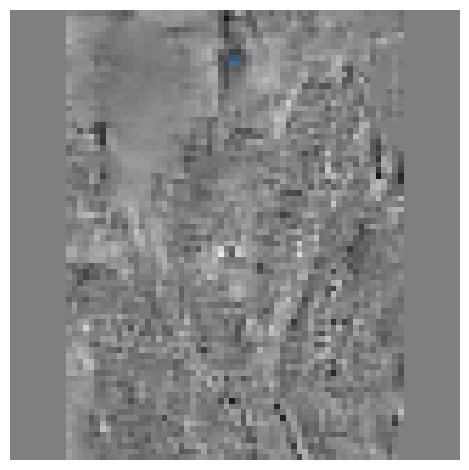

In [298]:
i = 1
j = 2
center_slices = get_center_slices(np.array(y[i][0] == 1, dtype=int))
slice_idx = center_slices[j][0]

fig = plt.figure()
plt.axis('off')
plt.imshow(inputs[i][0][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(y[i][0][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(y[i][0][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure()
plt.axis('off')
plt.imshow(inputs[i][0][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(preds[i][0][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(preds[i][0][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()

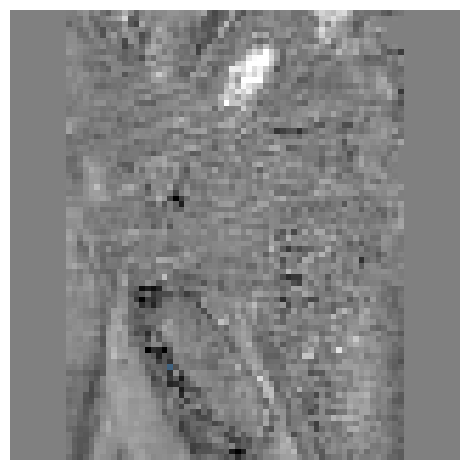

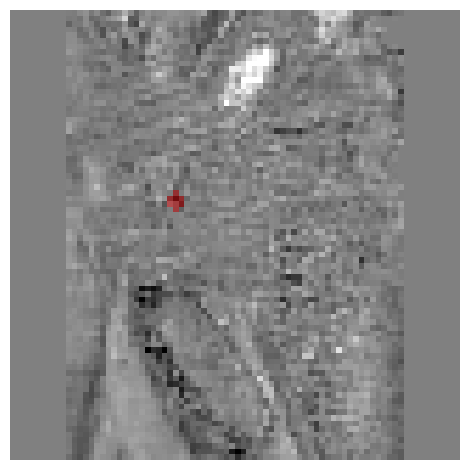

In [305]:
i = 0
j = 2
center_slices = get_center_slices(np.array(preds[i][0] == 1, dtype=int))
slice_idx = center_slices[j][0]

fig = plt.figure()
plt.axis('off')
plt.imshow(inputs[i][0][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(y[i][0][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(y[i][0][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()

fig = plt.figure()
plt.axis('off')
plt.imshow(inputs[i][0][slice_idx,:,:], cmap='gray', interpolation='nearest', vmin=-7, vmax=7)
plt.imshow(preds[i][0][slice_idx,:,:], cmap='Set1', vmin=1, vmax=9, alpha=np.array(preds[i][0][slice_idx,:,:] != 0, dtype=int) * 0.5, interpolation='nearest')
plt.tight_layout()
plt.show()
plt.close()